In [94]:
sample='LL653-E1-P1-TC_S17' #f'LL719-P1-CC_S1' , 
template='Tigre'
data_path=f'/n/groups/klein/shouwen/lili_project/DATA/CARLIN/20220717_SC_3A/TC' # path to CARLIN data folder
output_dir=f'/n/groups/klein/shouwen/lili_project/DATA/CARLIN/20220717_SC_3A/TC/CARLIN/Shouwen_Method/{sample}'
CARLIN_read_cutoff=3 # used to compare with CARLIN pipeline
cfg='scLimeCat' # ['sc10xV3',  'scLimeCat']
coarse_grained_readcutoff_floor=3 # the lower bound of the later read count filtering, after denoising, and re-group reads. 
distance_relative_threshold=0.03 # 5% error rate, will be multipled with the sequence length
read_ratio_threshold=0.6
seq_3prime_upper_N=15
seq_5prime_upper_N=None

In [141]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import yaml
from carlinhf import CARLIN as car
from carlinhf import larry
import importlib
importlib.reload(car)
importlib.reload(larry)
#%config InlineBackend.figure_format = 'svg' #'retina'         # or 'svg'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',100)
%matplotlib inline

# Single-cell CARLIN pipeline for Lime data

# Single-cell CARLIN pipeline for 10x data

In [96]:
CARLIN_dir=data_path+f'/CARLIN/results_cutoff_override_{CARLIN_read_cutoff}'

In [97]:
ref_name=cfg[2:]
df_ref_BC=pd.read_csv(f'/n/groups/klein/shouwen/lili_project/packages/snakemake_carlin/source/{ref_name}_barcodes.txt.gz',
                      sep='\t',header=None,names=['CB'],compression='gzip')

In [98]:
%%time
## load sequences
df_raw_reads=car.CARLIN_raw_reads(data_path+'/raw_fastq',sample,protocol=cfg)

CPU times: user 52 s, sys: 1.47 s, total: 53.5 s
Wall time: 53.5 s


In [129]:
df_N=df_raw_reads[df_raw_reads['cell_bc'].apply(lambda x: 'N' in x)]
print('N fraction:',len(df_N)/len(df_raw_reads))

N fraction: 0.0021024144006946783


In [101]:
%%time
df_filter_reads=car.CARLIN_preprocessing(df_raw_reads,template=template,ref_cell_barcodes=df_ref_BC['CB'],
                                         seq_3prime_upper_N=seq_3prime_upper_N,seq_5prime_upper_N=seq_5prime_upper_N)

Total fastq: 1066393
Fastq with vaid 3 and 5 prime: 838437 (0.79)
Fastq with valid barcodes: 747651 (0.70)
CPU times: user 6.79 s, sys: 423 ms, total: 7.21 s
Wall time: 7.2 s


## Check raw data qualities

Check raw data to decide the read cutoff. If we see a linear slope between read number per cell and clone number per cell, this is a signature of sequencing-error induced clonal diversity

In [102]:
#df_counts=larry.extract_putative_valid_cell_id(df_filter_reads,signal_threshold=2.5,cell_key="clone_id",)

Identified 22 putative cell_id


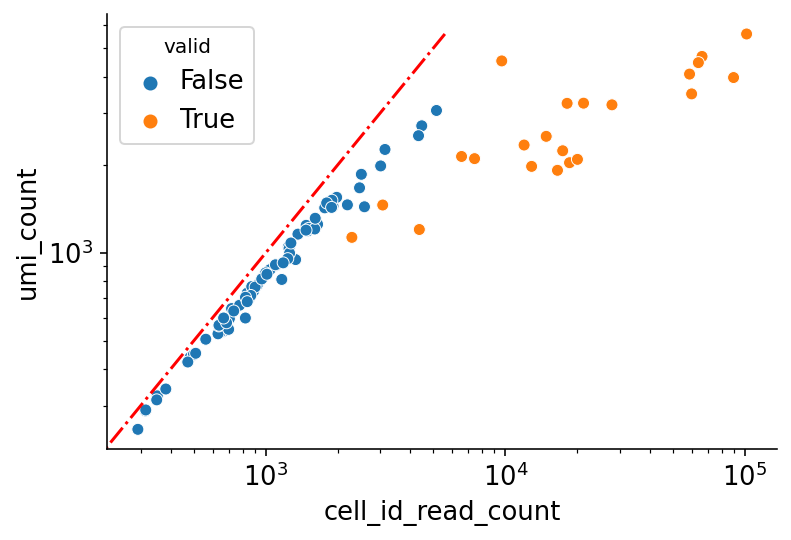

In [146]:
df_valid_cells=larry.extract_putative_valid_cell_id(df_filter_reads,signal_threshold=2,cell_key="cell_id",null_slope=1)

In [104]:
df_valid_cells

,cell_id,cell_id_read_count,umi_count,valid
0,LL653-E1-P1-TC_S17_AAACATCG,16508,1912,True
1,LL653-E1-P1-TC_S17_AACAACCA,2190,1457,True
13,LL653-E1-P1-TC_S17_ACACAGAA,4476,2714,True
18,LL653-E1-P1-TC_S17_ACCACTGT,12871,1972,True
19,LL653-E1-P1-TC_S17_ACCTCCAA,3015,1979,True
22,LL653-E1-P1-TC_S17_ACTATGCA,2286,1128,True
29,LL653-E1-P1-TC_S17_AGGCTAAC,3075,1455,True
32,LL653-E1-P1-TC_S17_AGTGGTCA,58772,4077,True
37,LL653-E1-P1-TC_S17_ATTGAGGA,18535,2030,True
38,LL653-E1-P1-TC_S17_ATTGGCTC,21211,3243,True


In [105]:
#df_read=larry.QC_read_per_molecule(df_filter_reads,target_keys=["umi"])

We are interested to see at what read cutoff the corresponding cell number or clone number conform to our expectation. For example, for scLimeCat, we only expect around 386cells, and ~300 clones

/n/groups/klein/shouwen/miniconda/miniconda_py37/envs/CoSpar_test/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/n/groups/klein/shouwen/miniconda/miniconda_py37/envs/CoSpar_test/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


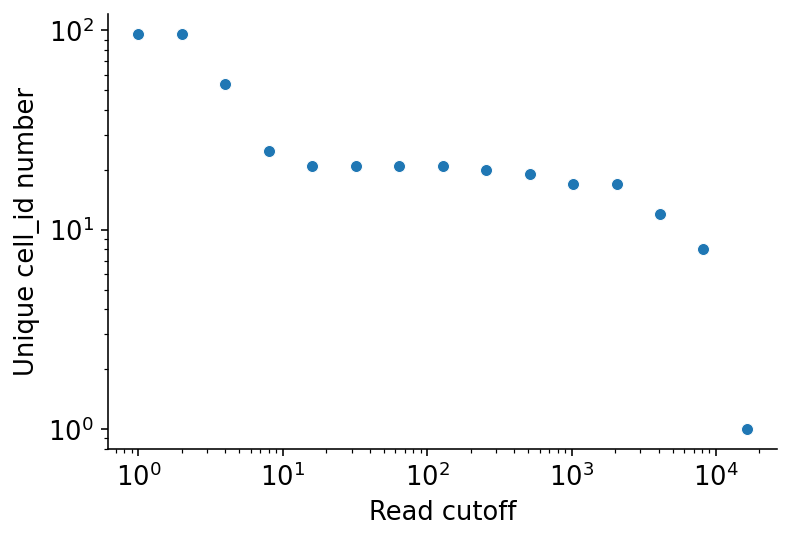

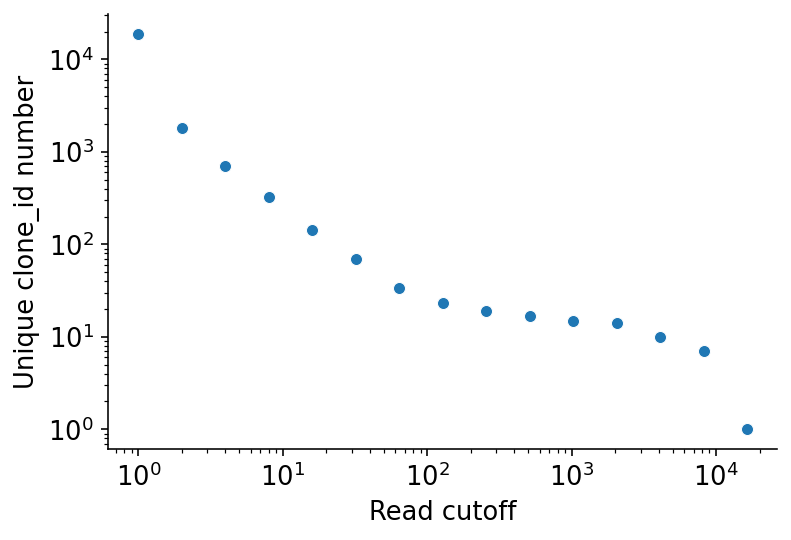

In [106]:
df_unique=larry.QC_unique_cells(df_filter_reads,target_keys=['cell_id','clone_id'])

In [107]:
larry.print_statistics(df_filter_reads)

library number: 1
cell_id number: 96
clone_id number: 18818
umi_id number: 135482
total reads: 748K


Plot distribution of unique clone barcode length. This informs how computationally expensive the following operation will be

Text(0.5, 1.0, 'Raw CARLIN length dist (UMI): 206864 count')

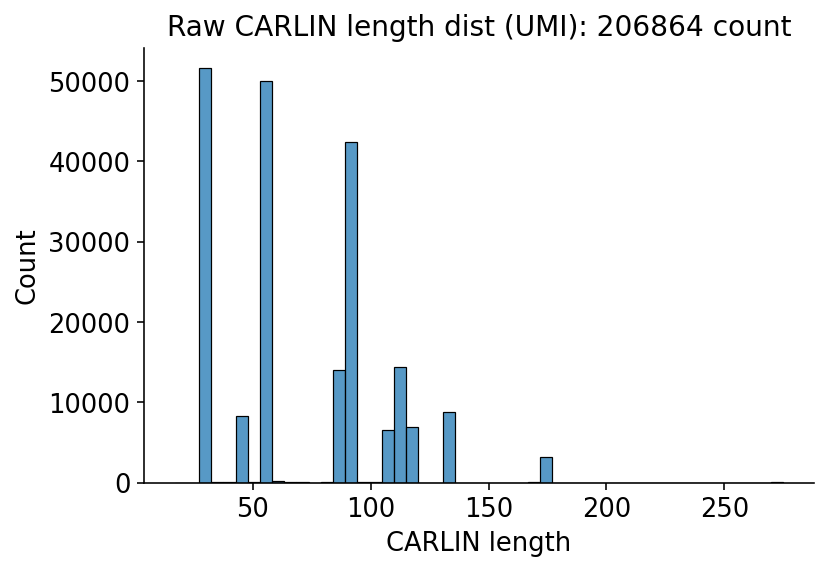

In [108]:
df_filter_reads['bc_length']=df_filter_reads['clone_id'].apply(lambda x: len(x))
unique_bc_length=df_filter_reads['bc_length'] #list(set(df_filter_reads['bc_length']))
ax=sns.histplot(unique_bc_length,bins=50)
ax.set_xlabel('CARLIN length')
ax.set_title(f'Raw CARLIN length dist (UMI): {len(unique_bc_length)} count')

Text(0.5, 1.0, 'Unique CARLIN length dist: 114 count')

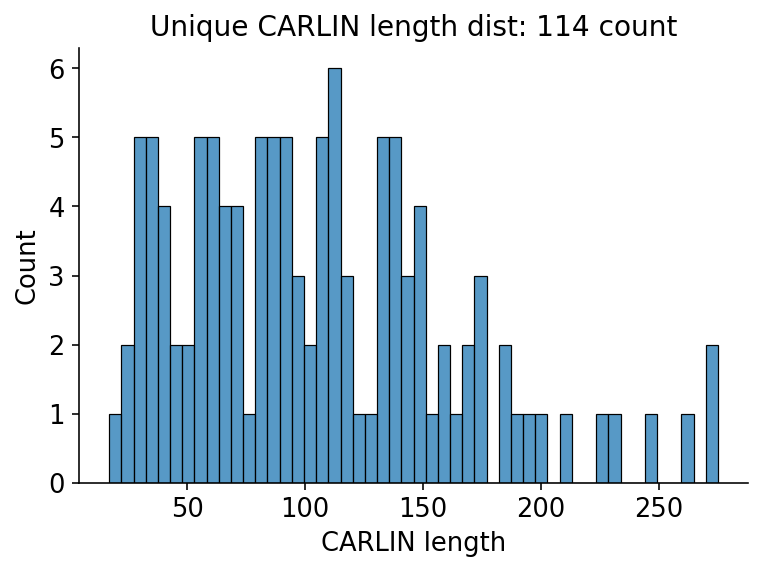

In [109]:
df_filter_reads['bc_length']=df_filter_reads['clone_id'].apply(lambda x: len(x))
unique_bc_length=list(set(df_filter_reads['bc_length']))
ax=sns.histplot(unique_bc_length,bins=50)
ax.set_xlabel('CARLIN length')
ax.set_title(f'Unique CARLIN length dist: {len(unique_bc_length)} count')

Denoise the clone id per each clone barcode length

We first perform barcode cleaning within a certian distance, then re-calculate the read number, and filter out low-read-count sequences. The read threshold is determined as the 10% of the max read count within each sequence length group, with a lower bound at coarse_grained_readcutoff_floor

## Collapse clone_id and filter cells within the same clone_id length

In [130]:
read_cutoff=2 # initial read count filtering 
# coarse_grained_readcutoff_floor=5 # the lower bound of the later read count filtering, after denoising, and re-group reads. 
# distance_relative_threshold=0.05 # 5% error rate, will be multipled with the sequence length
    
# use a low-filtering threshold, and also avoid filtering out valid_cell ids from above
def filter_low_read_cells(df,coarse_grained_readcutoff=None):
    if coarse_grained_readcutoff is None:
        coarse_grained_readcutoff=np.max([coarse_grained_readcutoff_floor,0.01*df['read'].max()])
    #print('coarse_grained_readcutoff=',coarse_grained_readcutoff)
    #df_out=larry.remove_cells(df,read_cutoff=coarse_grained_readcutoff)
    return df[(df['read']>=coarse_grained_readcutoff) | df['cell_id'].isin(df_valid_cells['cell_id'].unique())]

df_list=[]
unique_seq_length=list(set(df_filter_reads['bc_length']))
for target_length in sorted(unique_seq_length):
    df_tmp=df_filter_reads[df_filter_reads['bc_length']==target_length]#.groupby(['cell_bc','clone_id']).agg({'read':'sum'})
    df_HQ=larry.denoise_clonal_data(df_tmp,
        target_key="clone_id",
        read_cutoff=read_cutoff,
        distance_threshold=np.max([1,int(target_length*distance_relative_threshold)]),  
        whiteList=None,
        plot_report=False,
        progress_bar=False)

    df_HQ_group=larry.group_cells(df_HQ,group_keys=["library","cell_id","cell_bc","clone_id"])
    df_out=df_HQ_group.groupby('clone_id').apply(filter_low_read_cells).reset_index(drop=True)
    df_out['bc_length']=target_length
    df_list.append(df_out)
df_denoise_bc_1=pd.concat(df_list)

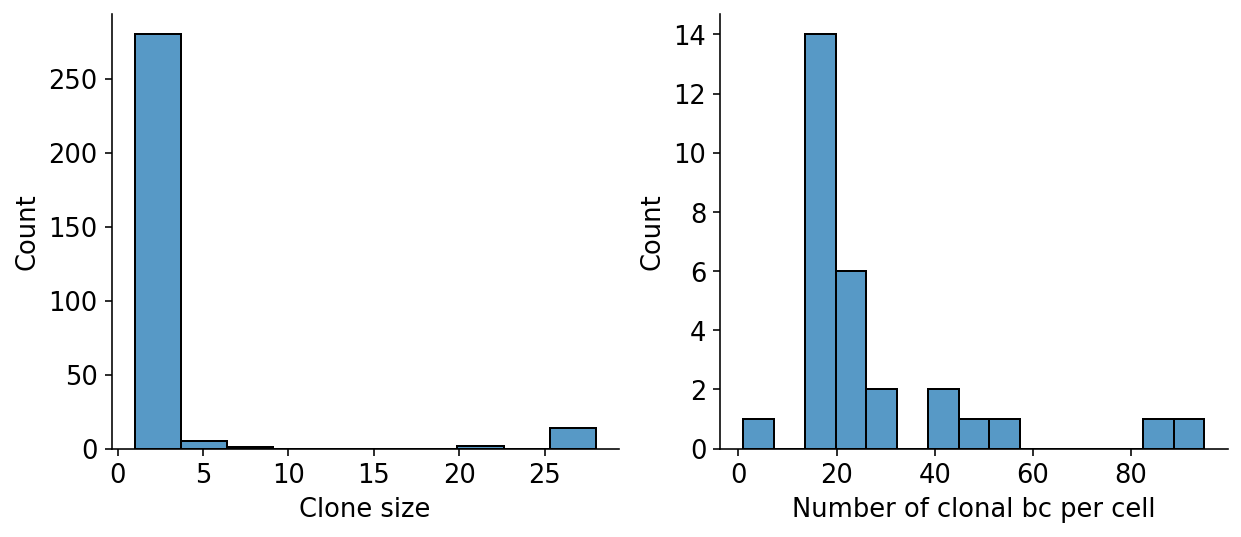

In [131]:
larry.QC_clonal_reports(df_denoise_bc_1)

In [132]:
larry.print_statistics(df_denoise_bc_1)

library number: 1
cell_id number: 29
clone_id number: 302
total reads: 571K


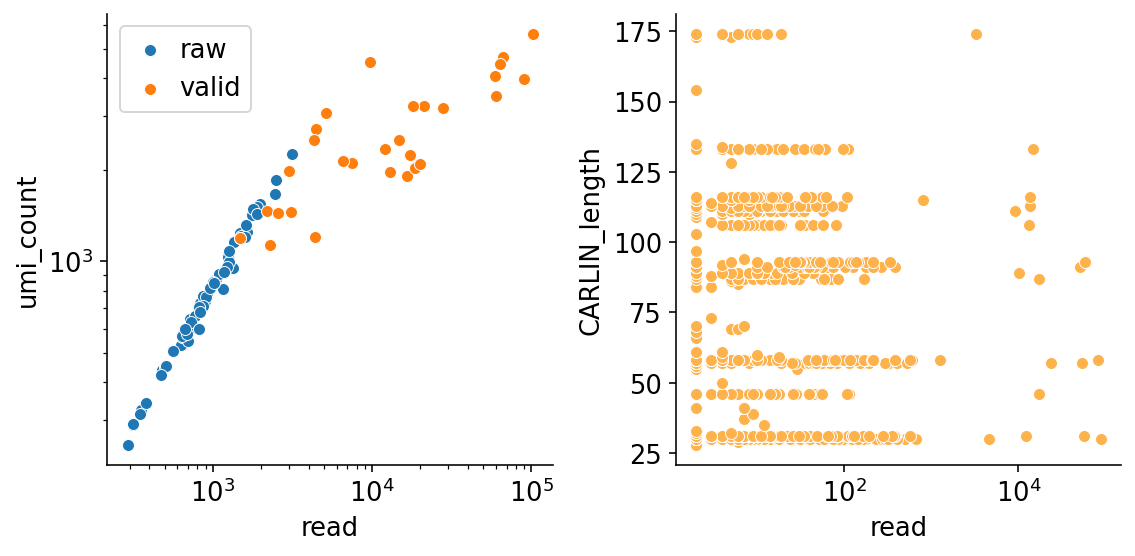

In [133]:
larry.QC_report_for_inferred_clones(df_filter_reads,df_denoise_bc_1)

## Select dominant clone_id within each cell_id

The above operation leaves some cell barcodes to have multiple clone barcodes. We select the read-dominant clonal barcodes as the putative clone id for each cell barcode.

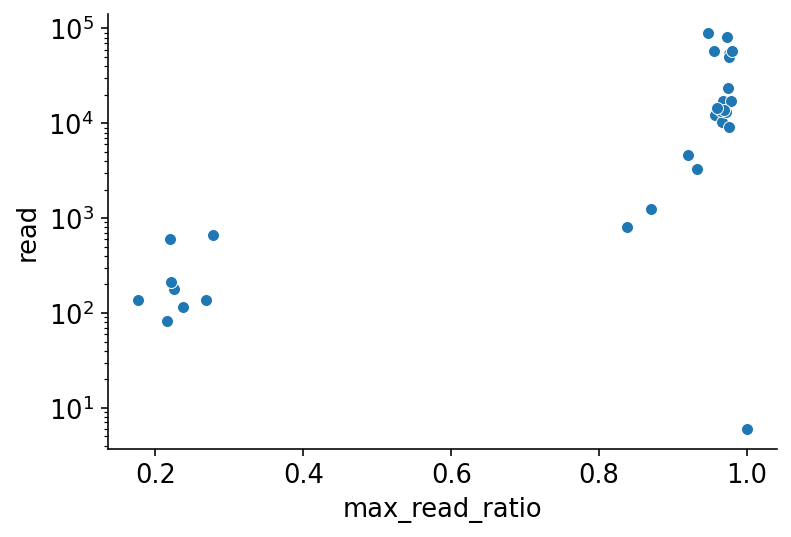

In [134]:
# select dominant barcode sequence within each cell barcode, we use a very high read_ratio to avoid false positive
#df_dominant_frac=car.calculate_read_fraction_for_dominant_sequences(df_denoise_bc_2,cell_bc_key='cell_bc',clone_key='clone_id')
df_dominant=car.obtain_read_dominant_sequences(df_denoise_bc_1,cell_bc_key='cell_bc',clone_key='clone_id')
sns.scatterplot(data=df_dominant,x='max_read_ratio',y='read')
plt.yscale('log')

Further filter out the cells where there is no clear dominant clone barcodes

In [135]:
#read_ratio_threshold=0.6
df_final=df_dominant[df_dominant['max_read_ratio']>read_ratio_threshold]

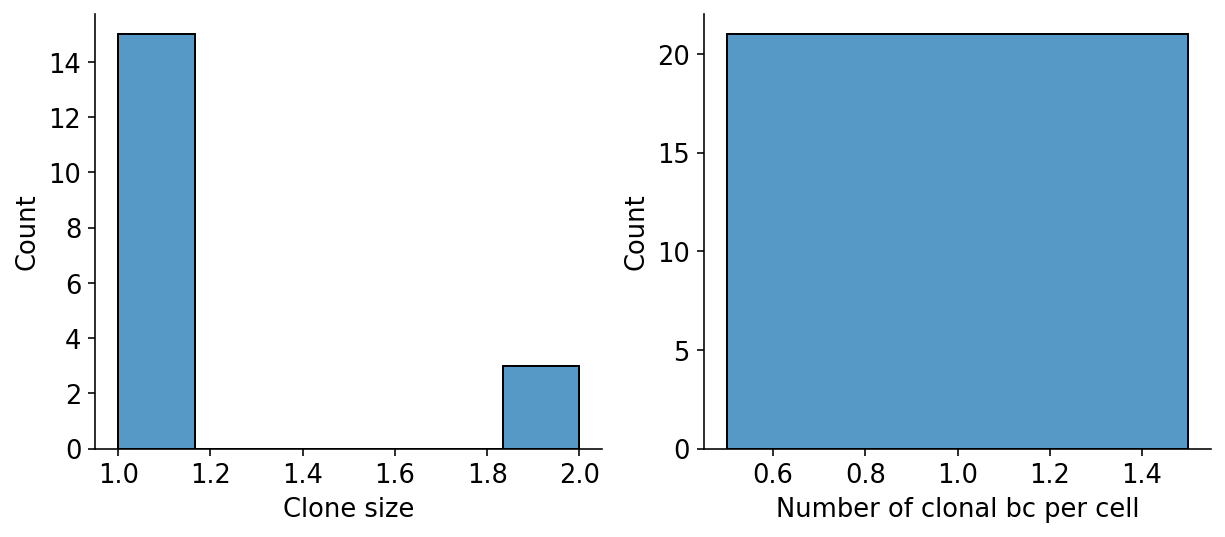

In [136]:
larry.QC_clonal_reports(df_final)

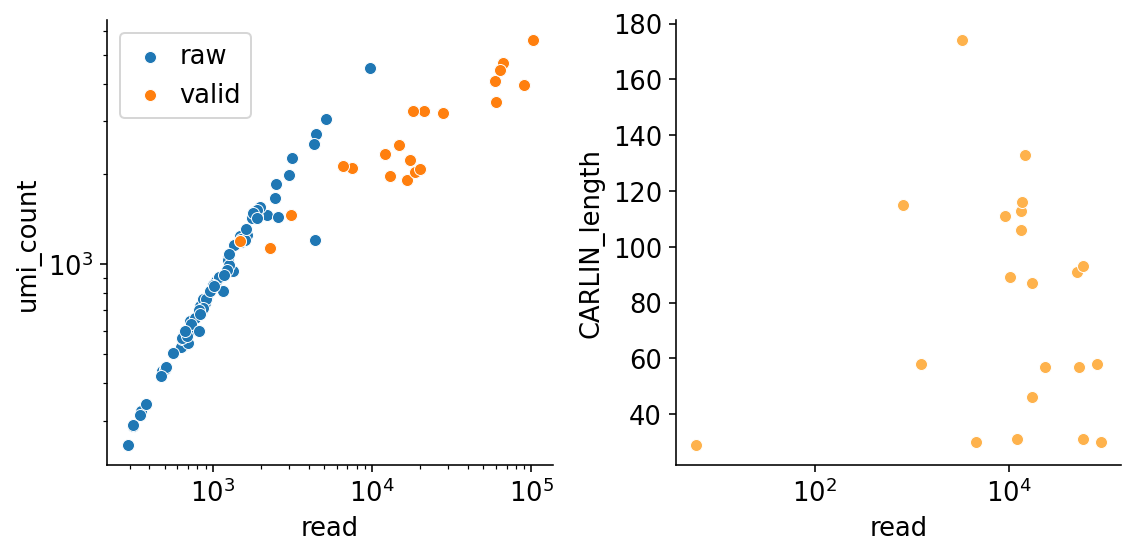

In [137]:
larry.QC_report_for_inferred_clones(df_filter_reads,df_final)

In [138]:
larry.print_statistics(df_final)

library number: 1
cell_id number: 21
clone_id number: 18
total reads: 543K


In [139]:
df_final.sort_values('CARLIN_length')

,library,cell_id,cell_bc,clone_id,umi_count,bc_length,CARLIN_length,read,max_read_ratio
0,LL653-E1-P1-TC_S17,LL653-E1-P1-TC_S17_CTGGCATA,CTGGCATA,TCGCCGGAGTCGACACGACTCGCTATGGA,1,29,29,6,1.000000
5,LL653-E1-P1-TC_S17,LL653-E1-P1-TC_S17_CTCAATGA,CTCAATGA,TCGCCGGAGTCGAGACGCTGACGCTATGGA,2937,30,30,88575,0.946698
6,LL653-E1-P1-TC_S17,LL653-E1-P1-TC_S17_GCCAAGAC,GCCAAGAC,TCGCCGGAGTCGAGACGCTGACGCTATGGA,535,30,30,4591,0.919487
7,LL653-E1-P1-TC_S17,LL653-E1-P1-TC_S17_CTGTAGCC,CTGTAGCC,TCGCCGGAGTCGAGACGCTGACGGCTATGGA,1114,31,31,12163,0.956587
8,LL653-E1-P1-TC_S17,LL653-E1-P1-TC_S17_GTCTGTCA,GTCTGTCA,TCGCCGGAGTCGAGACGCTGACGGCTATGGA,2584,31,31,57290,0.955789
9,LL653-E1-P1-TC_S17,LL653-E1-P1-TC_S17_TGGTGGTA,TGGTGGTA,TCGCCGGAGTCGACACGACTCGCGCATAGCGATGGAGTACTATGGA,723,46,46,17106,0.967096
10,LL653-E1-P1-TC_S17,LL653-E1-P1-TC_S17_CGCATACA,CGCATACA,TCGCCGGAGTCGAGACGCTGAATATGGAGTCGACACGACTCGCGCA...,2107,57,57,53201,0.974949
11,LL653-E1-P1-TC_S17,LL653-E1-P1-TC_S17_GTCGTAGA,GTCGTAGA,TCGCCGGAGTCGAGACGCTGAATATGGAGTCGACACGACTCGCGCA...,1430,57,57,23738,0.974386
15,LL653-E1-P1-TC_S17,LL653-E1-P1-TC_S17_TGAAGAGA,TGAAGAGA,TCGCCGGAGTCGAGACGCTGACGCATATGGAGTCGACACGACTCGC...,1856,58,58,81432,0.973078
17,LL653-E1-P1-TC_S17,LL653-E1-P1-TC_S17_AGGCTAAC,AGGCTAAC,TCGCCGGAGTCGAGACGCTGAGCGATGGGAGCGAGAGCGCGCTCGT...,133,58,58,1255,0.870319


In [120]:
df_final.to_csv(f'{output_dir}/called_barcodes_by_SW_method.csv',index=0)

In [121]:
# df_plot=df_filter_reads[df_filter_reads['clone_id'].isin(df_final['clone_id'].unique())]
# sns.histplot(df_plot['read'],log_scale=True)

## Compare with CARLIN pipeline

In [122]:
df_ref=car.extract_CARLIN_info(CARLIN_dir,[sample])

In [123]:
us_unique=set(df_final['clone_id'])
orig_pipeline_unique=set(df_ref['CARLIN'])
BC_insersect=us_unique.intersection(orig_pipeline_unique)
print(f'Dected unique clones by our method: {len(us_unique)}; by CARLIN pipeline: {len(orig_pipeline_unique)}; intersection: {len(BC_insersect)}')

Dected unique clones by our method: 18; by CARLIN pipeline: 17; intersection: 17


In [124]:
df_ref_flat=car.CARLIN_output_to_cell_by_barcode_long_table(df_ref)
df_ref_flat_new=df_ref_flat.merge(df_filter_reads,on=['cell_bc','clone_id']).groupby(
        ['cell_id','cell_bc','clone_id']).agg(read=('read','sum'),CARLIN_length=('bc_length','mean')).reset_index()
df_ref_flat_new['method']='CARLIN_pipeline'

df_joint=df_final.merge(df_ref_flat_new,on=['cell_id','cell_bc','clone_id'],how='inner').set_index('cell_id')
df_ref_flat_new=df_ref_flat_new.set_index('cell_id')
df_ref_flat_new.loc[df_joint.index,'read']=df_joint['read_x']
df_ref_flat_new=df_ref_flat_new.reset_index()

Text(0, 0.5, 'CARLIN sequence length')

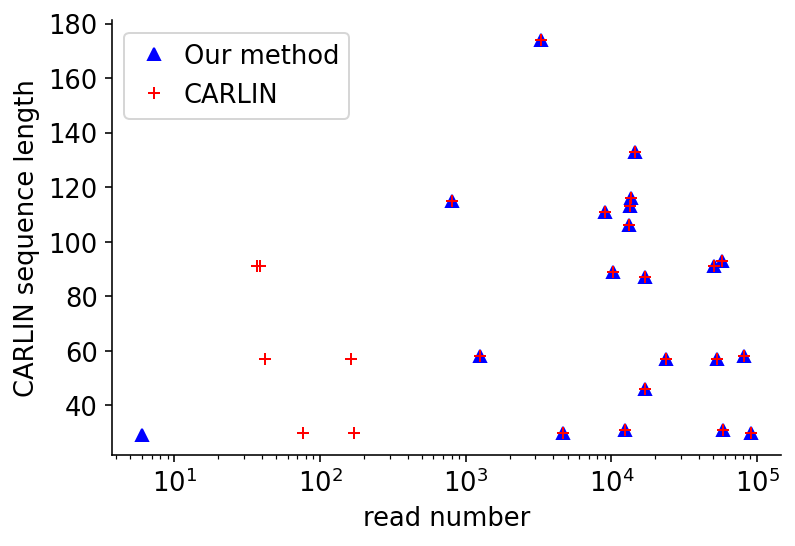

In [125]:
plt.plot(df_final['read'],df_final['CARLIN_length'],'^b',label='Our method')
plt.plot(df_ref_flat_new['read'],df_ref_flat_new['CARLIN_length'],'+r',label='CARLIN')
plt.xscale('log')
plt.legend()
plt.xlabel('read number')
plt.ylabel('CARLIN sequence length')

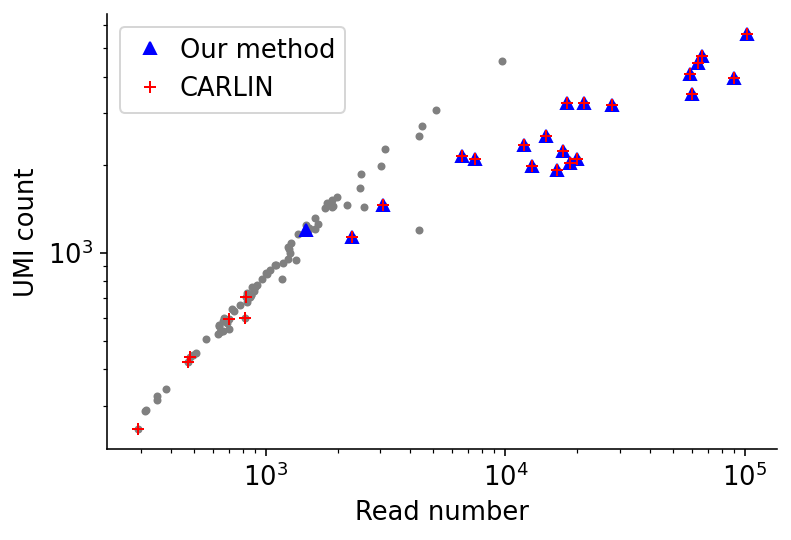

In [126]:
df_plot=df_filter_reads.groupby(['cell_id']).agg(read=('read','sum'),umi_count=('umi',lambda x: len(set(x)))).reset_index()
plt.plot(df_plot['read'],df_plot['umi_count'],'.',color='grey')
df_tmp=df_plot[df_plot['cell_id'].isin(df_final['cell_id'])]
plt.plot(df_tmp['read'],df_tmp['umi_count'],'^b',label='Our method')
df_tmp=df_plot[df_plot['cell_id'].isin(df_ref_flat_new['cell_id'])]
plt.plot(df_tmp['read'],df_tmp['umi_count'],'+r',label='CARLIN')
#sns.scatterplot(data=df_plot[df_plot['cell_id'].isin(df_ref_flat_new['cell_id'])],x='read',y='umi_count')
#plt.plot([2*10**2,10**4],[2*10**2,0.6*10**4])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Read number')
plt.ylabel('UMI count')
plt.legend()

In [127]:
df_final['method']='SW'
df_outer_joint=df_final.merge(df_ref_flat_new.drop(['read','CARLIN_length'],axis=1),on=['cell_id','cell_bc','clone_id'],
               how='outer').sort_values('CARLIN_length')
only_df_ref=df_ref_flat_new[df_ref_flat_new.cell_id.isin(df_outer_joint[pd.isna(df_outer_joint['library'])]['cell_id'])].set_index('cell_id')
df_outer_joint=df_outer_joint.set_index('cell_id')
for x in ['CARLIN_length','read']:
    df_outer_joint.loc[only_df_ref.index,x]=only_df_ref[x]
df_outer_joint=df_outer_joint.reset_index()
df_outer_joint

,cell_id,library,cell_bc,clone_id,umi_count,bc_length,CARLIN_length,read,max_read_ratio,method_x,method_y
0,LL653-E1-P1-TC_S17_CTGGCATA,LL653-E1-P1-TC_S17,CTGGCATA,TCGCCGGAGTCGACACGACTCGCTATGGA,1.0,29.0,29.0,6.0,1.000000,SW,NaN
1,LL653-E1-P1-TC_S17_CTCAATGA,LL653-E1-P1-TC_S17,CTCAATGA,TCGCCGGAGTCGAGACGCTGACGCTATGGA,2947.0,30.0,30.0,90342.0,0.965584,SW,CARLIN_pipeline
2,LL653-E1-P1-TC_S17_GCCAAGAC,LL653-E1-P1-TC_S17,GCCAAGAC,TCGCCGGAGTCGAGACGCTGACGCTATGGA,536.0,30.0,30.0,4633.0,0.927899,SW,CARLIN_pipeline
3,LL653-E1-P1-TC_S17_CTGTAGCC,LL653-E1-P1-TC_S17,CTGTAGCC,TCGCCGGAGTCGAGACGCTGACGGCTATGGA,1117.0,31.0,31.0,12426.0,0.977271,SW,CARLIN_pipeline
4,LL653-E1-P1-TC_S17_GTCTGTCA,LL653-E1-P1-TC_S17,GTCTGTCA,TCGCCGGAGTCGAGACGCTGACGGCTATGGA,2588.0,31.0,31.0,58594.0,0.977544,SW,CARLIN_pipeline
5,LL653-E1-P1-TC_S17_TGGTGGTA,LL653-E1-P1-TC_S17,TGGTGGTA,TCGCCGGAGTCGACACGACTCGCGCATAGCGATGGAGTACTATGGA,723.0,46.0,46.0,17106.0,0.967096,SW,CARLIN_pipeline
6,LL653-E1-P1-TC_S17_CGCATACA,LL653-E1-P1-TC_S17,CGCATACA,TCGCCGGAGTCGAGACGCTGAATATGGAGTCGACACGACTCGCGCA...,2107.0,57.0,57.0,53201.0,0.974949,SW,CARLIN_pipeline
7,LL653-E1-P1-TC_S17_GTCGTAGA,LL653-E1-P1-TC_S17,GTCGTAGA,TCGCCGGAGTCGAGACGCTGAATATGGAGTCGACACGACTCGCGCA...,1430.0,57.0,57.0,23738.0,0.974386,SW,CARLIN_pipeline
8,LL653-E1-P1-TC_S17_TGAAGAGA,LL653-E1-P1-TC_S17,TGAAGAGA,TCGCCGGAGTCGAGACGCTGACGCATATGGAGTCGACACGACTCGC...,1856.0,58.0,58.0,81432.0,0.973078,SW,CARLIN_pipeline
9,LL653-E1-P1-TC_S17_AGGCTAAC,LL653-E1-P1-TC_S17,AGGCTAAC,TCGCCGGAGTCGAGACGCTGAGCGATGGGAGCGAGAGCGCGCTCGT...,133.0,58.0,58.0,1255.0,0.870319,SW,CARLIN_pipeline


In [128]:
df_outer_joint.to_csv(f'{output_dir}/df_outer_joint.csv',index=0)